# Horse Feature DataFrame Generation with Train-Test Split

This notebook contains functions to load and analyze ground truth data for horse detection. It processes GeoJSON data and associated orthomosaic tiles to create a feature dataset suitable for machine learning. The notebook also implements a train-test split and exports the data in a format compatible with Hugging Face datasets.

## Setup and Imports

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from pathlib import Path
import os
from io import BytesIO
from tqdm import tqdm
import json
from sklearn.cluster import KMeans
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
from PIL import Image

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Constants for data directories relative to project root
DATA_DIR = "../data"
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
SPLITS_DIR = os.path.join(PROCESSED_DIR, "splits")
HF_DIR = os.path.join(DATA_DIR, "hf")
RESULTS_DIR = "../results"
DOCS_DIR = os.path.join(RESULTS_DIR, "docs")

# Create necessary directories
os.makedirs(SPLITS_DIR, exist_ok=True)
os.makedirs(HF_DIR, exist_ok=True)
os.makedirs(DOCS_DIR, exist_ok=True)

## Data Loading Functions

These functions handle loading and analyzing the ground truth data from GeoJSON files. The data contains point features representing horse presence/absence observations.

### `load_ground_truth`
Loads ground truth data from a GeoJSON file into a GeoDataFrame. The function includes basic error handling for file existence.

In [2]:
def load_ground_truth(
    filepath: str = "../data/vector/groundtruth.geojson",
) -> gpd.GeoDataFrame:
    """Load ground truth data from a GeoJSON file."""
    path = Path(filepath)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    return gpd.read_file(filepath)

### `get_point_info`
Extracts basic information about point features from the GeoDataFrame, including:
- Total number of points
- Available columns
- Spatial bounds of the data

In [3]:
def get_point_info(gdf: gpd.GeoDataFrame) -> dict:
    """Get basic information about point features."""
    points = gdf[gdf.geometry.type == "Point"]
    return {
        "total_points": len(points),
        "columns": list(points.columns),
        "bounds": points.total_bounds.tolist(),
    }

In [4]:
# Load the ground truth data
gdf = load_ground_truth()

# Get and display basic information
info = get_point_info(gdf)
print("Ground Truth Information:")
for key, value in info.items():
    print(f"{key}: {value}")

# Display the first few rows of the GeoDataFrame
print("\nFirst few rows of the ground truth data:")
display(gdf.head())

Ground Truth Information:
total_points: 1600
columns: ['idx', 'Presence', 'Zone', 'Period', 'Recency', 'Datetime', 'Latitude', 'Longitude', 'Easting', 'Northing', 'Ellipsoidal_height', 'geometry']
bounds: [728103.7675003844, 5173286.410967057, 728857.9386778023, 5173862.10999949]

First few rows of the ground truth data:


,idx,Presence,Zone,Period,Recency,Datetime,Latitude,Longitude,Easting,Northing,Ellipsoidal_height,geometry
0,0,1,1,1,1,2024-04-25 06:25:00.600000+00:00,46.678295,-114.007977,728825.999020,5.173764e+06,1182.161,POINT (728825.999 5173763.794)
1,1,1,1,1,1,2024-04-25 06:25:24.200000+00:00,46.678261,-114.007970,728826.721929,5.173760e+06,1181.317,POINT (728826.722 5173760.049)
2,2,1,1,1,1,2024-04-25 06:26:14+00:00,46.678299,-114.008067,728819.157326,5.173764e+06,1181.695,POINT (728819.157 5173764.064)
3,3,1,1,1,1,2024-04-25 06:26:49.400000+00:00,46.678331,-114.008220,728807.322341,5.173767e+06,1180.652,POINT (728807.322 5173767.093)
4,4,1,1,1,2,2024-04-25 06:27:05.200000+00:00,46.678280,-114.008122,728814.979743,5.173762e+06,1180.683,POINT (728814.98 5173761.785)


## Feature DataFrame Creation

This section handles the creation of a comprehensive DataFrame that combines ground truth data with orthomosaic information. The process involves:
- Converting GeoDataFrame to standard DataFrame
- Processing orthomosaic dates and directories
- Creating feature rows based on temporal relationships

### `create_feature_dataframe`
Creates a DataFrame by combining ground truth points with orthomosaic information. Key features:
- Uses all available orthomosaics for both presence and absence points
- Generates tile paths for each point-orthomosaic combination
- Adds an `observation_offset` column, which is a signed integer representing the number of days between the orthomosaic date and the ground truth date
  - Positive values indicate the orthomosaic was captured after the ground truth observation
  - Negative values indicate the orthomosaic was captured before the ground truth observation

In [5]:
def create_feature_dataframe(
    gdf: gpd.GeoDataFrame, tiles_dir: str = "../data/raster/tiles"
) -> gpd.GeoDataFrame:
    """
    Create a feature DataFrame by combining ground truth points with orthomosaic information.
    Only includes combinations where the corresponding tile file exists.
    
    Args:
        gdf: GeoDataFrame containing ground truth points
        tiles_dir: Directory containing orthomosaic tiles
        
    Returns:
        GeoDataFrame with features for each valid point-orthomosaic combination
    """
    # Retain the geometry column
    df = gdf.copy()
    df = df.rename(columns={'Datetime': 'datetime_groundtruth'})
    
    # Get and sort orthomosaics
    orthomosaics = sorted(
        [
            d
            for d in os.listdir(tiles_dir)
            if os.path.isdir(os.path.join(tiles_dir, d)) and not d.startswith(".")
        ]
    )

    # Convert dates
    ortho_dates = pd.to_datetime(
        [d.split("_")[0] for d in orthomosaics], format="%y%m%d", utc=True
    ).tz_localize(None)
    
    ortho_to_datetime = dict(zip(orthomosaics, ortho_dates))

    # Create rows for each orthomosaic and calculate observation offset
    rows = []
    skipped_tiles = 0
    total_combinations = 0
    
    print("Creating feature DataFrame with tile validation...")
    
    # Determine the correct file naming pattern
    # Try to find existing files to determine the pattern
    sample_dirs = [os.path.join(tiles_dir, ortho, "presence") for ortho in orthomosaics[:2]]
    sample_dirs.extend([os.path.join(tiles_dir, ortho, "absence") for ortho in orthomosaics[:2]])
    
    # Look for existing files to determine pattern
    file_pattern = None
    for sample_dir in sample_dirs:
        if os.path.exists(sample_dir):
            files = os.listdir(sample_dir)
            if files:
                # Check if files match the 4-digit pattern
                if any(re.match(r'\d{4}\.tif', f) for f in files):
                    file_pattern = "{:04d}.tif"
                    print(f"Using 4-digit file pattern: {file_pattern}")
                    break
                # Check if files match a different pattern (e.g., without leading zeros)
                elif any(re.match(r'\d+\.tif', f) for f in files):
                    file_pattern = "{}.tif"
                    print(f"Using simple file pattern: {file_pattern}")
                    break
    
    # Default to 4-digit pattern if we couldn't determine
    if not file_pattern:
        file_pattern = "{:04d}.tif"
        print(f"Could not determine file pattern, defaulting to: {file_pattern}")
    
    # Process each point
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing points"):
        row_date = pd.to_datetime(row["datetime_groundtruth"]).tz_localize(None)
        geometry = row.geometry
        point_idx = int(row['idx'])
        presence_folder = "presence" if row["Presence"] == 1 else "absence"

        for ortho, ortho_date in zip(orthomosaics, ortho_dates):
            total_combinations += 1
            
            # Generate the tile path using the determined pattern
            tile_filename = file_pattern.format(point_idx)
            tile_path = os.path.join(tiles_dir, ortho, presence_folder, tile_filename)
            
            # Check if the tile exists before adding it
            if os.path.exists(tile_path):
                new_row = row.to_dict()
                new_row["orthomosaic"] = ortho
                new_row["tile_path"] = tile_path
                new_row["observation_offset"] = (ortho_date - row_date).days
                new_row["datetime_aerialsurvey"] = ortho_to_datetime[ortho]
                new_row["geometry"] = geometry
                rows.append(new_row)
            else:
                skipped_tiles += 1

    # Create a GeoDataFrame from the rows
    feature_gdf = gpd.GeoDataFrame(rows)
    
    print(f"Created feature DataFrame with {len(feature_gdf)} valid point-orthomosaic combinations")
    print(f"Skipped {skipped_tiles} combinations (out of {total_combinations}) due to missing tiles")
    
    # Reorder columns in a consistent way
    desired_order = [
        'image', 'idx', 'Presence', 'Zone', 'Period', 'Recency', 
        'datetime_groundtruth', 'datetime_aerialsurvey', 'observation_offset',
        'Latitude', 'Longitude', 'Easting', 'Northing', 'Ellipsoidal_height',
        'geometry', 'orthomosaic', 'tile_path'
    ]

    # Only include columns that exist in the dataframe
    available_columns = [col for col in desired_order if col in feature_gdf.columns]

    # Add any columns that exist in the dataframe but aren't in the desired order
    missing_columns = [col for col in feature_gdf.columns if col not in desired_order]
    ordered_columns = available_columns + missing_columns

    feature_gdf = feature_gdf[ordered_columns]

    print("\nFeature DataFrame info:")
    print(feature_gdf.info())
    
    
    return feature_gdf

## Train-Test Split Functions

This section contains functions for creating a stratified train-test split of the data. The split is designed to maintain the distribution of presence/absence points while ensuring spatial and temporal representativeness.

### `filter_absences_near_presences`
Filters out absence points that are within a specified distance of any presence point. This helps ensure that absence points are truly representative of areas without horses, rather than being near-misses of presence points.

In [6]:
def filter_absences_near_presences(gdf, buffer_distance=2):
    """
    Filter out absence points that are within buffer_distance meters of any presence point.
    
    Args:
        gdf: GeoDataFrame containing both presence and absence points
        buffer_distance: Distance in meters to buffer around presence points
        
    Returns:
        GeoDataFrame containing only valid absence points
    """
    # Split into presence and absence
    presence_gdf = gdf[gdf['Presence'] == 1]
    absence_gdf = gdf[gdf['Presence'] == 0]
    
    print(f"Original absence points: {len(absence_gdf)}")
    
    # Create buffers around presence points
    presence_buffers = presence_gdf.copy()
    presence_buffers.geometry = presence_gdf.geometry.buffer(buffer_distance)
    
    # Find absences that intersect with any presence buffer
    valid_absences = absence_gdf.copy()
    to_remove = []
    
    for idx, absence in tqdm(absence_gdf.iterrows(), total=len(absence_gdf), desc="Filtering absences"):
        for _, buffer in presence_buffers.iterrows():
            if absence.geometry.intersects(buffer.geometry):
                to_remove.append(idx)
                break
    
    valid_absences = valid_absences.drop(to_remove)
    print(f"Valid absence points (after removing those within {buffer_distance}m of presences): {len(valid_absences)}")
    
    return valid_absences

### `create_spatial_blocks`
Creates spatial blocks using K-means clustering on point coordinates. This function helps ensure that the train-test split is spatially representative by grouping points based on their geographic proximity.

In [7]:
def create_spatial_blocks(gdf, n_clusters=10):
    """
    Create spatial blocks using K-means clustering on point coordinates.
    
    Args:
        gdf: GeoDataFrame containing points
        n_clusters: Number of spatial blocks to create
        
    Returns:
        GeoDataFrame with an additional 'spatial_block' column
    """
    # Extract coordinates for clustering
    coords = np.array([(p.x, p.y) for p in gdf.geometry])
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
    clusters = kmeans.fit_predict(coords)
    
    # Add cluster labels to the GeoDataFrame
    result_gdf = gdf.copy()
    result_gdf['spatial_block'] = clusters
    
    return result_gdf

### `create_train_test_split`
Creates a train-test split according to specific criteria:
1. For absences: exclude any absence found within 2 meters of a presence (at any time point), then create spatial blocks using K-means clustering and sample 20% randomly from each block
2. For presences: group by zone and period, sampling 20% randomly from each group

This approach ensures that the test set is representative of the full dataset across both spatial and temporal dimensions.

In [8]:
def create_train_test_split(gdf, test_size=0.2):
    """
    Create train/test split according to specific criteria:
    1. For absences: exclude any absence found within 2 meters of a presence,
       then create spatial blocks and sample test_size from each block
    2. For presences: group by zone and period, sampling test_size from each group
    
    Args:
        gdf: GeoDataFrame containing both presence and absence points
        test_size: Proportion of data to include in the test split
        
    Returns:
        train_gdf, test_gdf: GeoDataFrames for training and testing
    """
    # Split into presence and absence
    presence_gdf = gdf[gdf['Presence'] == 1].copy()
    absence_gdf = gdf[gdf['Presence'] == 0].copy()
    
    # Filter absences near presences
    valid_absences = filter_absences_near_presences(gdf)
    
    # Create spatial blocks for absences
    absence_blocks = create_spatial_blocks(valid_absences)
    
    # Initialize lists to store indices
    presence_test_indices = []
    presence_train_indices = []
    absence_test_indices = []
    absence_train_indices = []
    
    # Split presences by zone and period
    for (zone, period), group in presence_gdf.groupby(['Zone', 'Period']):
        if len(group) > 0:
            # Calculate number of test samples for this group
            n_test = max(1, int(len(group) * test_size))
            
            # Randomly select indices for test set
            group_indices = group.index.tolist()
            test_idx = random.sample(group_indices, n_test)
            train_idx = [idx for idx in group_indices if idx not in test_idx]
            
            # Add to master lists
            presence_test_indices.extend(test_idx)
            presence_train_indices.extend(train_idx)
    
    # Split absences by spatial block
    for block, group in absence_blocks.groupby('spatial_block'):
        if len(group) > 0:
            # Calculate number of test samples for this block
            n_test = max(1, int(len(group) * test_size))
            
            # Randomly select indices for test set
            group_indices = group.index.tolist()
            test_idx = random.sample(group_indices, n_test)
            train_idx = [idx for idx in group_indices if idx not in test_idx]
            
            # Add to master lists
            absence_test_indices.extend(test_idx)
            absence_train_indices.extend(train_idx)
    
    # Combine test and train indices
    test_indices = presence_test_indices + absence_test_indices
    train_indices = presence_train_indices + absence_train_indices
    
    # Create test and train dataframes
    test_gdf = gdf.loc[test_indices].copy()
    train_gdf = gdf.loc[train_indices].copy()
    
    # Print split statistics
    print(f"Total points: {len(gdf)}")
    print(f"Training points: {len(train_gdf)} ({len(train_gdf)/len(gdf)*100:.1f}%)")
    print(f"Testing points: {len(test_gdf)} ({len(test_gdf)/len(gdf)*100:.1f}%)")
    
    # Check class distribution in each split
    print("\nClass distribution in training set:")
    print(train_gdf['Presence'].value_counts(normalize=True) * 100)
    
    print("\nClass distribution in test set:")
    print(test_gdf['Presence'].value_counts(normalize=True) * 100)
    
    return train_gdf, test_gdf, train_indices, test_indices

### `visualize_train_test_split`
Creates a visualization of the train-test split, showing the spatial distribution of presence and absence points in both the training and testing sets. This visualization helps to verify that the spatial stratification is working correctly and that the test set is representative of the overall data distribution.

In [9]:
def visualize_train_test_split(train_gdf, test_gdf, figsize=(14, 12)):
    """
    Visualize the train-test split on a map.
    
    Args:
        train_gdf: GeoDataFrame containing training points
        test_gdf: GeoDataFrame containing testing points
        figsize: Figure size as a tuple (width, height)
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot training points
    train_presence = train_gdf[train_gdf['Presence'] == 1]
    train_absence = train_gdf[train_gdf['Presence'] == 0]
    
    # Plot testing points
    test_presence = test_gdf[test_gdf['Presence'] == 1]
    test_absence = test_gdf[test_gdf['Presence'] == 0]
    
    # Plot each category with different colors and markers
    ax.scatter(train_presence.geometry.x, train_presence.geometry.y, 
               c='forestgreen', marker='o', s=50, alpha=0.7, label='Train - Presence')
    ax.scatter(train_absence.geometry.x, train_absence.geometry.y, 
               c='lightblue', marker='o', s=50, alpha=0.7, label='Train - Absence')
    ax.scatter(test_presence.geometry.x, test_presence.geometry.y, 
               c='darkgreen', marker='X', s=80, alpha=0.9, label='Test - Presence')
    ax.scatter(test_absence.geometry.x, test_absence.geometry.y, 
               c='darkblue', marker='X', s=80, alpha=0.9, label='Test - Absence')
    
    # Add title and labels
    ax.set_title('Train-Test Split Visualization', fontsize=16)
    ax.set_xlabel('Easting', fontsize=14)
    ax.set_ylabel('Northing', fontsize=14)
    
    # Add legend
    ax.legend(fontsize=12, loc='best')
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

## Tile Encoding Functions

This section contains functions for processing and encoding tiles, both individually and in batch. These functions handle the conversion of image data into formats suitable for machine learning and provide progress tracking and error handling.

### `encode_tile`
Reads a GeoTIFF tile and encodes it as a standard image format (PNG). The function:
- Loads the raster data using rasterio
- Transposes data from (channels, height, width) to (height, width, channels)
- Converts to a PIL Image with appropriate handling for different channel configurations
- Saves as PNG to a BytesIO object
- Returns the encoded data as bytes

### `encode_all_tiles`
Processes and encodes all tiles in the DataFrame. Key features:
- Uses tqdm for progress tracking
- Handles encoding errors gracefully
- Provides summary statistics of successful/failed encodings
- Returns a filtered DataFrame containing only successfully encoded tiles
- Includes batch processing capability for memory efficiency

In [10]:
def encode_tile(tile_path: str) -> tuple:
    """
    Read a GeoTIFF tile and encode it as bytes, also returning transform data.
    This simplifies downstream loading and usage in machine learning pipelines.
    
    Args:
        tile_path: Path to the GeoTIFF tile
        
    Returns:
        tuple: (image_bytes, transform_dict) where image_bytes is the binary PNG data and
               transform_dict contains the rasterio transform parameters
    """
    if not os.path.exists(tile_path):
        raise FileNotFoundError(f"Tile not found: {tile_path}")

    with rasterio.open(tile_path) as src:
        # Extract transform information
        transform = src.transform
        transform_dict = {
            "a": transform.a, "b": transform.b, "c": transform.c,
            "d": transform.d, "e": transform.e, "f": transform.f
        }
        
        # Read the image data
        data = src.read()
        
        # Transpose from (channels, height, width) to (height, width, channels)
        data = np.transpose(data, (1, 2, 0))
        
        # Convert to PIL Image
        if data.shape[2] == 4:  # RGBA
            img = Image.fromarray(data.astype(np.uint8))
        elif data.shape[2] == 3:  # RGB
            img = Image.fromarray(data.astype(np.uint8))
        elif data.shape[2] == 1:  # Grayscale
            img = Image.fromarray(data[:, :, 0].astype(np.uint8))
        else:
            # Handle other channel configurations (use first 3 channels)
            img = Image.fromarray(data[:, :, :3].astype(np.uint8))
        
        # Save as PNG to BytesIO
        bio = BytesIO()
        img.save(bio, format='PNG')
        bio.seek(0)
        
        # Return both the image bytes and transform information
        return bio.read(), transform_dict

In [20]:
def encode_all_tiles(df: pd.DataFrame, batch_size: int = 100) -> pd.DataFrame:
    """
    Encode all tiles in the DataFrame.
    
    Args:
        df: DataFrame containing information about tiles
        batch_size: Number of tiles to process in each batch
        
    Returns:
        DataFrame with encoded tiles and transform information
    """
    # Convert GeoDataFrame to regular DataFrame to avoid indexing issues
    if isinstance(df, gpd.GeoDataFrame):
        result_df = pd.DataFrame(df.drop(columns=['geometry']).copy())
        has_geometry = True
    else:
        result_df = df.copy()
        has_geometry = False
    
    # Check if tile_path exists in the DataFrame
    if 'tile_path' not in df.columns:
        raise ValueError("DataFrame must contain a 'tile_path' column. Please run create_feature_dataframe first.")
    
    # Verify that tile paths exist before attempting to encode
    valid_paths = result_df['tile_path'].apply(os.path.exists)
    if not valid_paths.all():
        invalid_count = (~valid_paths).sum()
        print(f"Warning: {invalid_count} tile paths do not exist. These will be skipped during encoding.")
        # Optionally show some examples
        if invalid_count > 0:
            invalid_examples = result_df.loc[~valid_paths, 'tile_path'].head(5).tolist()
            print("Examples of invalid paths:")
            for path in invalid_examples:
                print(f"  - {path}")
    
    # Initialize image and transform columns
    result_df["image"] = None
    result_df["transform"] = None
    failed_encodings = []
    successful_encodings = 0

    # Process tiles - use enumerate with itertuples for more reliable indexing
    for i, row in tqdm(enumerate(df.itertuples()), total=len(df), desc="Encoding tiles"):
        try:
            tile_path = row.tile_path
            if os.path.exists(tile_path):
                image_bytes, transform_dict = encode_tile(tile_path)
                try:
                    # Use at method for safer assignment with binary data
                    result_df.at[result_df.index[i], "image"] = image_bytes
                    result_df.at[result_df.index[i], "transform"] = transform_dict
                    successful_encodings += 1
                except Exception as e:
                    failed_encodings.append((tile_path, f"DataFrame update error: {str(e)}"))
            else:
                failed_encodings.append((tile_path, "File not found"))
        except Exception as e:
            # Get more detailed error information including line number
            import traceback
            error_details = traceback.format_exc()
            failed_encodings.append((getattr(row, 'tile_path', f"Row {i}"), f"{str(e)}\n{error_details[:200]}..."))

    # Report failures in more detail
    if failed_encodings:
        print(f"\nFailed to encode {len(failed_encodings)} tiles out of {len(df)}")
        print(f"Failure rate: {len(failed_encodings)/len(df)*100:.2f}%")
        # Print the first few failures
        if len(failed_encodings) > 0:
            print("First few failures:")
            for path, error in failed_encodings[:5]:
                print(f"  - {path}: {error}")
    
    # Report success
    success_mask = result_df["image"].notna()
    actually_successful = success_mask.sum()
    print(f"\nSuccessfully encoded {actually_successful} out of {len(df)} tiles")
    
    # Verify consistency between counted successes and DataFrame non-null values
    if actually_successful != successful_encodings:
        print(f"Warning: Success count mismatch! DataFrame shows {actually_successful} successes, but {successful_encodings} were counted during processing.")
    
    # Move image to the first column and transform to the last column
    cols = result_df.columns.tolist()
    new_cols = ["image"] + [col for col in cols if col != "image" and col != "transform"] + ["transform"]
    result_df = result_df[new_cols]
    
    # Only filter if we have any successful encodings
    if actually_successful > 0:
        # Return only successfully encoded tiles
        return result_df[success_mask].copy()
    else:
        # If no successful encodings, raise a clear error
        error_summary = "\n".join([f"- {path}: {error.split('\\n')[0]}" for path, error in failed_encodings[:5]])
        raise RuntimeError(f"Failed to encode any tiles. Check your file paths and encoding function. First few errors:\n{error_summary}")

## Data Storage Functions

This section handles the efficient storage of processed data. The functions here manage the serialization of DataFrames into parquet format for use with Hugging Face datasets.

### `save_to_parquet`
Saves a GeoDataFrame to parquet file(s) with automatic versioning for large files. Key features:
- Creates directory structure if it doesn't exist
- Converts geometry to WKT format for storage
- Automatically splits files larger than 500 MB into versioned chunks
- Provides detailed reporting on file sizes and chunk distribution
- Supports both size-based and row-based chunking strategies

The versioning system helps manage large datasets by:
1. Preventing creation of excessively large files
2. Maintaining compatibility with systems that have file size limitations
3. Enabling more efficient parallel processing of data chunks
4. Using consistent file naming conventions for easy identification

In [12]:
def save_to_parquet(df, output_path, max_size_mb=1000, rows_per_file=None):
    """
    Save DataFrame to parquet format with versioning support for large files.
    
    If the file is estimated to be larger than max_size_mb, it will be split into multiple
    versioned files. 
    
    Args:
        df: DataFrame to save
        output_path: Path to save the parquet file (relative to ../data/hf/)
        max_size_mb: Maximum file size in MB before splitting into versions
        rows_per_file: Optional number of rows per file (overrides max_size_mb)
    """
    # Ensure output path is relative to ../data/hf/
    if not output_path.startswith('../data/hf/'):
        output_path = os.path.join('../data/hf', output_path)
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Create a copy and remove geometry and tile_path columns if they exist
    df_clean = df.copy()
    
    # For empty transform columns, add a default empty dict structure
    if 'transform' in df_clean.columns and df_clean['transform'].isna().any():
        # Replace None with empty dict with the same keys
        default_transform = {'a': 0.0, 'b': 0.0, 'c': 0.0, 'd': 0.0, 'e': 0.0, 'f': 0.0}
        df_clean['transform'] = df_clean['transform'].fillna(default_transform)
    
    # Standardize datetime columns to be timezone-aware in UTC format
    # Handle datetime_groundtruth column
    if 'datetime_groundtruth' in df_clean.columns:
        if not hasattr(df_clean['datetime_groundtruth'].dtype, 'tz'):
            df_clean['datetime_groundtruth'] = df_clean['datetime_groundtruth'].dt.tz_localize('UTC')
    
    # Handle datetime_aerialsurvey column
    if 'datetime_aerialsurvey' in df_clean.columns:
        if not hasattr(df_clean['datetime_aerialsurvey'].dtype, 'tz'):
            df_clean['datetime_aerialsurvey'] = df_clean['datetime_aerialsurvey'].dt.tz_localize('UTC')
    
    # Define the exact columns to keep in the specified order
    desired_columns = [
        'image', 'idx', 'Presence', 'Zone', 'Period', 'Recency', 
        'datetime_groundtruth', 'datetime_aerialsurvey', 'observation_offset',
        'Latitude', 'Longitude', 'Easting', 'Northing', 'Ellipsoidal_height', 'orthomosaic', 'transform'
    ]

    # Filter to only include columns that exist in the dataframe
    available_columns = [col for col in desired_columns if col in df_clean.columns]
    
    # Check if any desired columns are missing
    missing_columns = [col for col in desired_columns if col not in df_clean.columns]
    if missing_columns:
        print(f"\nWarning: The following desired columns are missing from the dataframe: {missing_columns}")
    
    # Select only the available desired columns
    df_clean = df_clean[available_columns]
    
    # Now print DataFrame information for verification AFTER cleaning
    print(f"\n{'='*80}")
    print(f"DataFrame Verification for: {os.path.basename(output_path)}")
    print(f"{'='*80}")
    print(f"Shape: {df_clean.shape} (rows, columns)")
    print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")
    print(f"Column dtypes:")
    for col, dtype in df_clean.dtypes.items():
        print(f"  - {col}: {dtype}")
    
    # Print sample of data AFTER cleaning
    print("\nData sample (first 5 rows):")
    display(df_clean.head())
    
    # Check for missing values AFTER cleaning
    missing_values = df_clean.isna().sum()
    if missing_values.sum() > 0:
        print("\nMissing values by column:")
        for col, count in missing_values.items():
            if count > 0:
                print(f"  - {col}: {count} ({count/len(df_clean)*100:.2f}%)")
    else:
        print("\nNo missing values found.")
    
    # Print final DataFrame structure right before saving
    print("\nFinal DataFrame structure before saving:")
    print(f"Shape: {df_clean.shape} (rows, columns)")
    print("Columns:", df_clean.columns.tolist())
    
    # Estimate size of DataFrame in memory (rough approximation)
    estimated_size_mb = df_clean.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"\nEstimated DataFrame size: {estimated_size_mb:.2f} MB")
    
    # Determine if we need to split the file
    if rows_per_file is not None:
        # Use specified rows per file
        need_versioning = len(df_clean) > rows_per_file
    else:
        # Use size-based estimation
        need_versioning = estimated_size_mb > max_size_mb
    
    if need_versioning:
        # Split into multiple files
        if rows_per_file is None:
            # Calculate rows per file based on size
            rows_per_file = max(1, int(len(df_clean) * (max_size_mb / estimated_size_mb)))
        
        # Get base filename and extension
        base_path, ext = os.path.splitext(output_path)
        
        # Split and save in chunks
        total_chunks = (len(df_clean) + rows_per_file - 1) // rows_per_file  # Ceiling division
        
        print(f"Splitting into {total_chunks} files with approximately {rows_per_file} rows each")
        
        # Save each chunk
        for i in range(total_chunks):
            start_idx = i * rows_per_file
            end_idx = min((i + 1) * rows_per_file, len(df_clean))
            
            # Create versioned filename with 2-digit numbering
            version_path = f"{base_path}_{i+1:02d}{ext}"
            
            # Save this chunk
            chunk_df = df_clean.iloc[start_idx:end_idx]
            chunk_df.to_parquet(version_path, index=False)
            
            print(f"Saved {len(chunk_df)} rows to {version_path}")
        
        print(f"Total rows saved across {total_chunks} files: {len(df_clean)}")
        
    else:
        # Save as a single file
        df_clean.to_parquet(output_path, index=False)
        print(f"Saved {len(df_clean)} rows to {output_path}")
    
    print(f"{'='*80}\n")

## Main Processing Pipeline

This section executes the complete data processing pipeline:
1. Loads and analyzes ground truth data
2. Creates the feature DataFrame
3. Creates a train-test split
4. Saves split information
5. Encodes tiles for both train and test sets
6. Saves the processed data in parquet format for Hugging Face

The pipeline includes comprehensive error handling and progress reporting at each step.


Ground Truth Information:
total_points: 1600
columns: ['idx', 'Presence', 'Zone', 'Period', 'Recency', 'Datetime', 'Latitude', 'Longitude', 'Easting', 'Northing', 'Ellipsoidal_height', 'geometry']
bounds: [728103.7675003844, 5173286.410967057, 728857.9386778023, 5173862.10999949]
Original absence points: 716


Filtering absences:   0%|          | 0/716 [00:00<?, ?it/s]

Filtering absences: 100%|██████████| 716/716 [00:12<00:00, 58.00it/s]


Valid absence points (after removing those within 2m of presences): 706
Total ground truth points: 1600
Training points: 1278 (79.9%)
Testing points: 312 (19.5%)

Visualizing train-test split...


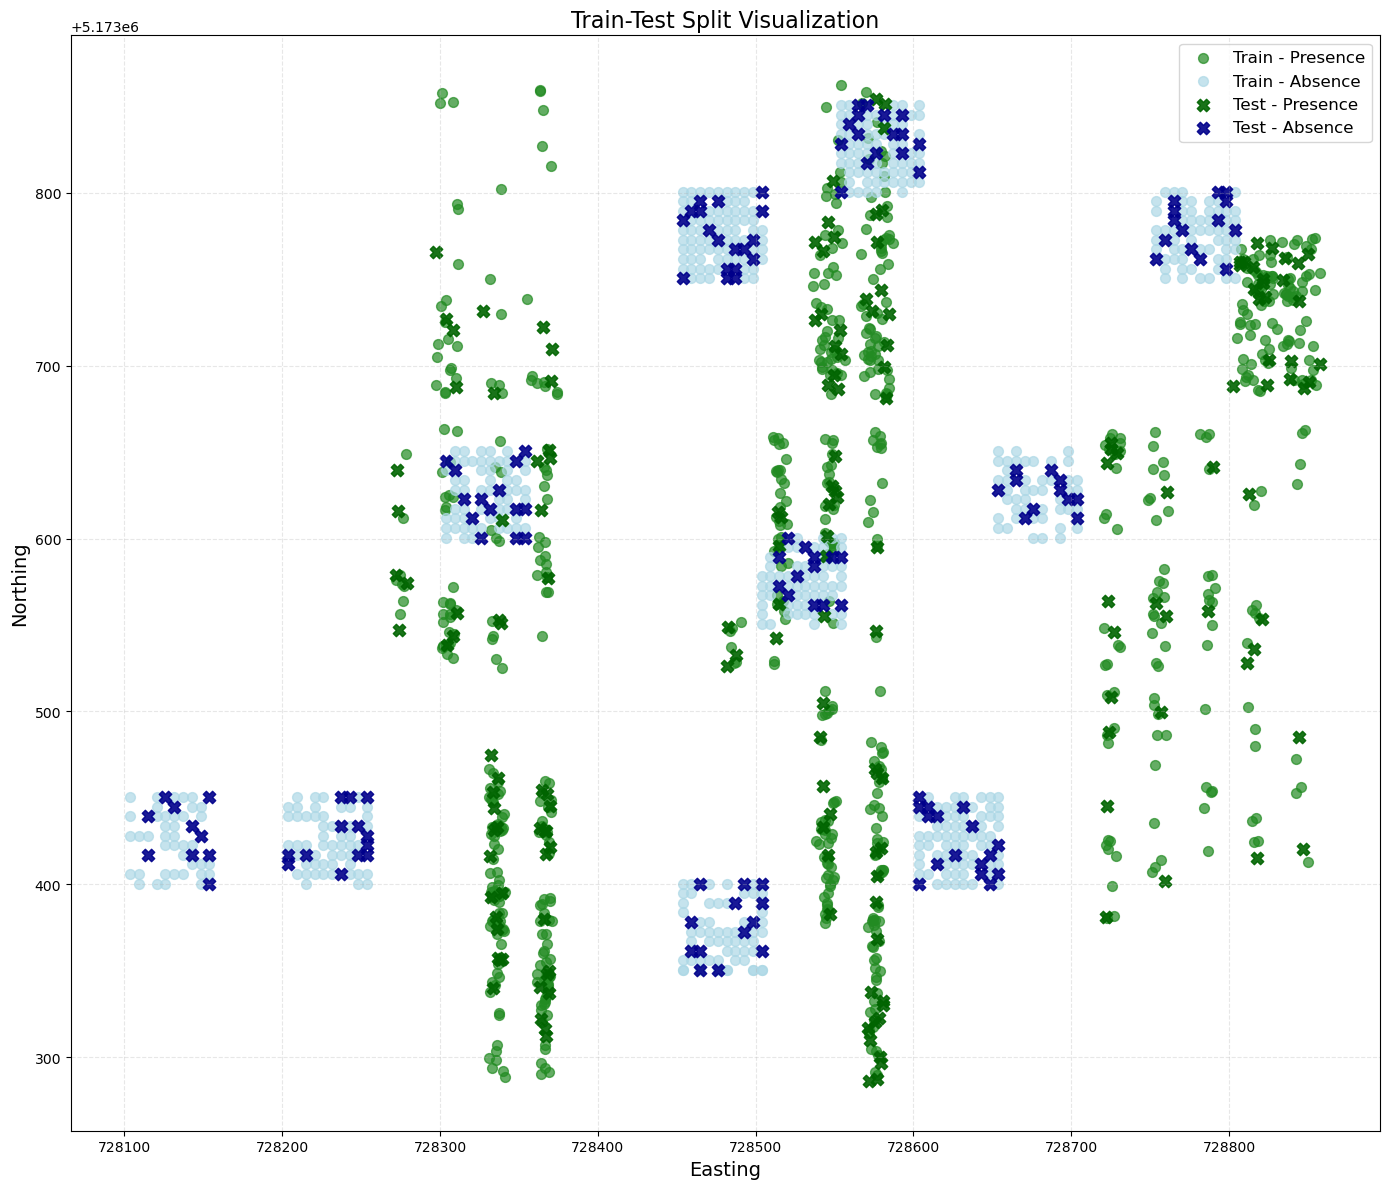


Creating feature DataFrames...
Creating feature DataFrame with tile validation...
Using simple file pattern: {}.tif


Processing points: 100%|██████████| 1278/1278 [00:00<00:00, 7828.34it/s]


Created feature DataFrame with 12780 valid point-orthomosaic combinations
Skipped 0 combinations (out of 12780) due to missing tiles

Feature DataFrame info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12780 entries, 0 to 12779
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   idx                    12780 non-null  int64              
 1   Presence               12780 non-null  int64              
 2   Zone                   12780 non-null  int64              
 3   Period                 12780 non-null  int64              
 4   Recency                12780 non-null  int64              
 5   datetime_groundtruth   12780 non-null  datetime64[ns, UTC]
 6   datetime_aerialsurvey  12780 non-null  datetime64[ns]     
 7   observation_offset     12780 non-null  int64              
 8   Latitude               12780 non-null  float64            
 9   Longitude       

Processing points: 100%|██████████| 312/312 [00:00<00:00, 7811.55it/s]


Created feature DataFrame with 3120 valid point-orthomosaic combinations
Skipped 0 combinations (out of 3120) due to missing tiles

Feature DataFrame info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3120 entries, 0 to 3119
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   idx                    3120 non-null   int64              
 1   Presence               3120 non-null   int64              
 2   Zone                   3120 non-null   int64              
 3   Period                 3120 non-null   int64              
 4   Recency                3120 non-null   int64              
 5   datetime_groundtruth   3120 non-null   datetime64[ns, UTC]
 6   datetime_aerialsurvey  3120 non-null   datetime64[ns]     
 7   observation_offset     3120 non-null   int64              
 8   Latitude               3120 non-null   float64            
 9   Longitude           

Encoding tiles: 100%|██████████| 12780/12780 [08:22<00:00, 25.44it/s]



Successfully encoded 12780 out of 12780 tiles

Encoding testing tiles...


Encoding tiles: 100%|██████████| 3120/3120 [02:02<00:00, 25.54it/s]


Successfully encoded 3120 out of 3120 tiles

DataFrame Verification for: train.parquet
Shape: (12780, 16) (rows, columns)
Memory usage: 2881.83 MB
Column dtypes:
  - image: object
  - idx: int64
  - Presence: int64
  - Zone: int64
  - Period: int64
  - Recency: int64
  - datetime_groundtruth: datetime64[ns, UTC]
  - datetime_aerialsurvey: datetime64[ns, UTC]
  - observation_offset: int64
  - Latitude: float64
  - Longitude: float64
  - Easting: float64
  - Northing: float64
  - Ellipsoidal_height: float64
  - orthomosaic: object
  - transform: object

Data sample (first 5 rows):


,image,idx,Presence,Zone,Period,Recency,datetime_groundtruth,datetime_aerialsurvey,observation_offset,Latitude,Longitude,Easting,Northing,Ellipsoidal_height,orthomosaic,transform
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,1,1,1,2024-04-25 06:25:00.600000+00:00,2024-04-24 00:00:00+00:00,-2,46.678295,-114.007977,728825.99902,5.173764e+06,1182.161,240424_upperpartridge,"{'a': 0.012814267946732936, 'b': 0.0, 'c': 728..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,1,1,1,2024-04-25 06:25:00.600000+00:00,2024-05-06 00:00:00+00:00,10,46.678295,-114.007977,728825.99902,5.173764e+06,1182.161,240506_upperpartridge,"{'a': 0.012814274899431334, 'b': 0.0, 'c': 728..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,1,1,1,2024-04-25 06:25:00.600000+00:00,2024-05-24 00:00:00+00:00,28,46.678295,-114.007977,728825.99902,5.173764e+06,1182.161,240524_upperpartridge,"{'a': 0.012814355263395132, 'b': 0.0, 'c': 728..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,1,1,1,2024-04-25 06:25:00.600000+00:00,2024-06-04 00:00:00+00:00,39,46.678295,-114.007977,728825.99902,5.173764e+06,1182.161,240604_upperpartridge,"{'a': 0.012814355263396767, 'b': 0.0, 'c': 728..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,1,1,1,2024-04-25 06:25:00.600000+00:00,2024-06-20 00:00:00+00:00,55,46.678295,-114.007977,728825.99902,5.173764e+06,1182.161,240620_upperpartridge,"{'a': 0.012814427455697278, 'b': 0.0, 'c': 728..."



No missing values found.

Final DataFrame structure before saving:
Shape: (12780, 16) (rows, columns)
Columns: ['image', 'idx', 'Presence', 'Zone', 'Period', 'Recency', 'datetime_groundtruth', 'datetime_aerialsurvey', 'observation_offset', 'Latitude', 'Longitude', 'Easting', 'Northing', 'Ellipsoidal_height', 'orthomosaic', 'transform']

Estimated DataFrame size: 2881.83 MB
Splitting into 6 files with approximately 2217 rows each
Saved 2217 rows to ../data/hf/train_01.parquet
Saved 2217 rows to ../data/hf/train_02.parquet
Saved 2217 rows to ../data/hf/train_03.parquet
Saved 2217 rows to ../data/hf/train_04.parquet
Saved 2217 rows to ../data/hf/train_05.parquet
Saved 1695 rows to ../data/hf/train_06.parquet
Total rows saved across 6 files: 12780


DataFrame Verification for: test.parquet
Shape: (3120, 16) (rows, columns)
Memory usage: 704.69 MB
Column dtypes:
  - image: object
  - idx: int64
  - Presence: int64
  - Zone: int64
  - Period: int64
  - Recency: int64
  - datetime_groundtrut

,image,idx,Presence,Zone,Period,Recency,datetime_groundtruth,datetime_aerialsurvey,observation_offset,Latitude,Longitude,Easting,Northing,Ellipsoidal_height,orthomosaic,transform
0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,7,1,1,1,2,2024-04-25 06:27:34.800000+00:00,2024-04-24 00:00:00+00:00,-2,46.678267,-114.008227,728807.010238,5.173760e+06,1179.226,240424_upperpartridge,"{'a': 0.012814267946732936, 'b': 0.0, 'c': 728..."
1,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,7,1,1,1,2,2024-04-25 06:27:34.800000+00:00,2024-05-06 00:00:00+00:00,10,46.678267,-114.008227,728807.010238,5.173760e+06,1179.226,240506_upperpartridge,"{'a': 0.012814274899431334, 'b': 0.0, 'c': 728..."
2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,7,1,1,1,2,2024-04-25 06:27:34.800000+00:00,2024-05-24 00:00:00+00:00,28,46.678267,-114.008227,728807.010238,5.173760e+06,1179.226,240524_upperpartridge,"{'a': 0.012814355263395132, 'b': 0.0, 'c': 728..."
3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,7,1,1,1,2,2024-04-25 06:27:34.800000+00:00,2024-06-04 00:00:00+00:00,39,46.678267,-114.008227,728807.010238,5.173760e+06,1179.226,240604_upperpartridge,"{'a': 0.012814355263396767, 'b': 0.0, 'c': 728..."
4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,7,1,1,1,2,2024-04-25 06:27:34.800000+00:00,2024-06-20 00:00:00+00:00,55,46.678267,-114.008227,728807.010238,5.173760e+06,1179.226,240620_upperpartridge,"{'a': 0.012814427455697278, 'b': 0.0, 'c': 728..."



No missing values found.

Final DataFrame structure before saving:
Shape: (3120, 16) (rows, columns)
Columns: ['image', 'idx', 'Presence', 'Zone', 'Period', 'Recency', 'datetime_groundtruth', 'datetime_aerialsurvey', 'observation_offset', 'Latitude', 'Longitude', 'Easting', 'Northing', 'Ellipsoidal_height', 'orthomosaic', 'transform']

Estimated DataFrame size: 704.69 MB
Splitting into 2 files with approximately 2213 rows each
Saved 2213 rows to ../data/hf/test_01.parquet
Saved 907 rows to ../data/hf/test_02.parquet
Total rows saved across 2 files: 3120


Processing complete. Dataset is ready for Hugging Face.


In [22]:
if __name__ == "__main__":
    try:
        # Load and analyze ground truth data
        gdf = load_ground_truth()

        # Print basic information
        info = get_point_info(gdf)
        print("\nGround Truth Information:")
        for key, value in info.items():
            print(f"{key}: {value}")

        # First, filter absences near presences in the original ground truth data
        presence_gdf = gdf[gdf['Presence'] == 1].copy()
        valid_absences = filter_absences_near_presences(gdf)
        
        # Create spatial blocks for absences
        absence_blocks = create_spatial_blocks(valid_absences)
        
        # Initialize lists to store indices
        presence_test_indices = []
        presence_train_indices = []
        absence_test_indices = []
        absence_train_indices = []
        
        # Split presences by zone and period
        test_size = 0.2
        for (zone, period), group in presence_gdf.groupby(['Zone', 'Period']):
            if len(group) > 0:
                # Calculate number of test samples for this group
                n_test = max(1, int(len(group) * test_size))
                
                # Randomly select indices for test set
                group_indices = group.index.tolist()
                test_idx = random.sample(group_indices, n_test)
                train_idx = [idx for idx in group_indices if idx not in test_idx]
                
                # Add to master lists
                presence_test_indices.extend(test_idx)
                presence_train_indices.extend(train_idx)
        
        # Split absences by spatial block
        for block, group in absence_blocks.groupby('spatial_block'):
            if len(group) > 0:
                # Calculate number of test samples for this block
                n_test = max(1, int(len(group) * test_size))
                
                # Randomly select indices for test set
                group_indices = group.index.tolist()
                test_idx = random.sample(group_indices, n_test)
                train_idx = [idx for idx in group_indices if idx not in test_idx]
                
                # Add to master lists
                absence_test_indices.extend(test_idx)
                absence_train_indices.extend(train_idx)
        
        # Combine test and train indices
        gt_test_indices = presence_test_indices + absence_test_indices
        gt_train_indices = presence_train_indices + absence_train_indices
        
        # Create train and test GeoDataFrames from the original ground truth data
        gt_test_gdf = gdf.loc[gt_test_indices].copy()
        gt_train_gdf = gdf.loc[gt_train_indices].copy()
        
        # Print split statistics for ground truth data
        print(f"Total ground truth points: {len(gdf)}")
        print(f"Training points: {len(gt_train_gdf)} ({len(gt_train_gdf)/len(gdf)*100:.1f}%)")
        print(f"Testing points: {len(gt_test_gdf)} ({len(gt_test_gdf)/len(gdf)*100:.1f}%)")
        
        # Save the ground truth GeoDataFrames as GeoJSON for reference
        gt_train_gdf.to_file(os.path.join(SPLITS_DIR, 'train_split.geojson'), driver='GeoJSON', index=False)
        gt_test_gdf.to_file(os.path.join(SPLITS_DIR, 'test_split.geojson'), driver='GeoJSON', index=False)
        
        # Visualize the train-test split on the ground truth data
        print("\nVisualizing train-test split...")
        fig, ax = visualize_train_test_split(gt_train_gdf, gt_test_gdf)
        plt.show()
        
        # Now create feature DataFrames for train and test sets separately
        print("\nCreating feature DataFrames...")
        train_feature_gdf = create_feature_dataframe(gt_train_gdf)
        test_feature_gdf = create_feature_dataframe(gt_test_gdf)
        
        # Print feature DataFrame info
        print("\nTrain Feature DataFrame Info:")
        print(train_feature_gdf.info())
        print("\nTest Feature DataFrame Info:")
        print(test_feature_gdf.info())
        
        # Save the indices as JSON for reference
        split_indices = {
            'train_indices': gt_train_indices,
            'test_indices': gt_test_indices,
            'metadata': {
                'random_seed': RANDOM_SEED,
                'train_size': len(gt_train_indices),
                'test_size': len(gt_test_indices),
                'train_presence_count': len(gt_train_gdf[gt_train_gdf['Presence'] == 1]),
                'train_absence_count': len(gt_train_gdf[gt_train_gdf['Presence'] == 0]),
                'test_presence_count': len(gt_test_gdf[gt_test_gdf['Presence'] == 1]),
                'test_absence_count': len(gt_test_gdf[gt_test_gdf['Presence'] == 0]),
            }
        }
        
        with open(os.path.join(SPLITS_DIR, 'split_indices.json'), 'w') as f:
            json.dump(split_indices, f, indent=2)
        
        # Process and encode tiles for training set
        print("\nEncoding training tiles...")
        train_encoded_df = encode_all_tiles(train_feature_gdf)
        
        # Process and encode tiles for testing set
        print("\nEncoding testing tiles...")
        test_encoded_df = encode_all_tiles(test_feature_gdf)
        
        # Reorder columns to make 'image' the first column
        cols = train_encoded_df.columns.tolist()
        cols.remove('image')
        train_encoded_df = train_encoded_df[['image'] + cols]

        # Do the same for test data
        cols = test_encoded_df.columns.tolist()
        cols.remove('image')
        test_encoded_df = test_encoded_df[['image'] + cols]
        
        # Save to parquet files in the format required by Hugging Face
        save_to_parquet(
            train_encoded_df, 
            'train.parquet',  # This will be saved to ../data/hf/train.parquet
            max_size_mb=500
        )
        save_to_parquet(
            test_encoded_df, 
            'test.parquet',  # This will be saved to ../data/hf/test.parquet
            max_size_mb=500
        )       
        
        print("\nProcessing complete. Dataset is ready for Hugging Face.")

    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()